## Portfolio construction:

This work is the supporting code of my blog in the medium platform. 

The blog is a walk through a simple mathematicla explanation of how a portfolio multi-factor risk model is build  and the how a robustly diversifed portfolio can be constructed from this model.  The portfolio risk and assets risk exposures are estimated  using five years of historical data from yahoo finace and the Fam-French five-factors model dataset.


The diversification process is based on the variation of the factor exposures according to the  Fam-French  risk factors. I name this approach as a Factor-exposure-based diversifion.


Diversification reduces portfolio's overall  risk exposure. 


Below is the supporting code!

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import statsmodels.api as sm

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

### Construction

Reussable class for estimating a the risk of the constructed  portfolio.

In [21]:
class portfolio_risk_and_beta_estimates(object):

    def __init__(self, list_of_tickers, return_df, risk_factors_data, factor_names):
        self.ticker_list = list_of_tickers
        self.risk_factors_df = risk_factors_data
        self.risk_factor_names = factor_names
        self.daily_ret = return_df

    def estimate_risk_exposure_and_specific_returns(self):

        betas = []
        specific_returns = []
        
        for ticker in self.ticker_list:

            df = self.daily_ret[[ticker]]
            model_data = df.merge(self.risk_factors_df, on='date').dropna()

            # for each ticker, pick the corresponding stock return time series and 
            # estimate factor betas via ordinary least square regression analysis
            ols_model = sm.OLS(endog=model_data[ticker], exog=sm.add_constant(model_data[self.risk_factor_names]))
            factor_model = ols_model.fit()
            factor_model = factor_model.params.rename({'const':'intercept'})
            
            # store the estimated factor betas into a list
            beta_estimates = pd.DataFrame(factor_model).rename(columns={0:ticker}).T.drop(['intercept'], axis=1)
            betas.append(beta_estimates)

            # calculate the specific returns and store into a list
            risk_factors = model_data.drop([ticker, 'RF'], axis=1)
            common_ret = risk_factors.dot(beta_estimates.values.T).rename(columns={0:'common_ret'})
            specific_ret = model_data[[ticker]].subtract(common_ret['common_ret'], axis=0)
            specific_returns.append(specific_ret)

        factor_exposures_df = pd.concat(betas, axis=0)
        specific_returns_df = pd.concat(specific_returns, axis=1)
        estimated_data_dict = {'beta exposures':factor_exposures_df, 
                        'specific returns':specific_returns_df,
                        'risk factors': risk_factors}
        

        return estimated_data_dict
    

    
    def estimate_portfolio_risk(self, annualized_coef=252):
        '''
            The function estimate the portfolio risk using the matrix formula
            therefore, les matrix B, F, S and X are estimated first.

            inputs:
                    annualized_coef: conventional coefficient to calculate annualized metrics in finance.
            return:
                    risk_p: the estimate portfolio risk
                     
        '''

        estimated_data = self.estimate_risk_exposure_and_specific_returns()
        # estimate annualized factor covariance matrix F
        F = annualized_coef*np.cov(estimated_data['risk factors'].T, ddof=1)
        # estimate annualized specific returns variance S
        S = annualized_coef*np.diag(estimated_data['specific returns'].var(ddof=1))
        # facor exposure matrix B
        B = estimated_data['beta exposures'].values
        # Choose portfolio weigths: for neutrality, I choose to distribute 
        # weights uniformly accross all assets of the portfolio.
        X = np.repeat(1/len(self.ticker_list), len(self.ticker_list))

        # now estimate the portfolio risk
        risk_p = np.sqrt(np.dot(np.dot(X.T, (np.dot(np.dot(B, F), B.T) + S)), X))

        print(f'\nEstimated Portfolio  Risk in Percentage:  {risk_p*100:.1f}%')


        return risk_p



    def plot_estimated_risk_exposures(self, title, figure_size=(12, 5)):

        estimated_data = self.estimate_risk_exposure_and_specific_returns()
        fig, ax = plt.subplots(figsize=figure_size)
        num_tickers = len(self.ticker_list)
        num_factors = len(self.risk_factor_names)
        bar_width = 0.05
        indices = np.arange(num_factors)


        for i, ticker in enumerate(self.ticker_list):
            bar_positions = indices + i * bar_width
            ax.bar(bar_positions, estimated_data['beta exposures'].loc[ticker], width=bar_width, label=ticker)
            
        #ax.set_xlabel('Factors', fontsize=10)
        ax.set_ylabel('Exposure Level', fontsize=10)
        ax.set_title(title, fontsize=13, fontweight='bold')
                    
        ax.set_xticks(indices + bar_width * (num_factors / 2) - bar_width / 2)
        ax.set_xticklabels(self.risk_factor_names)
        plt.grid(axis='y', color='gray', linestyle='--', alpha=.3)


        ax.legend(ncol=len(self.ticker_list), title='Ticker', fontsize=7.1)
        plt.show()
        
    


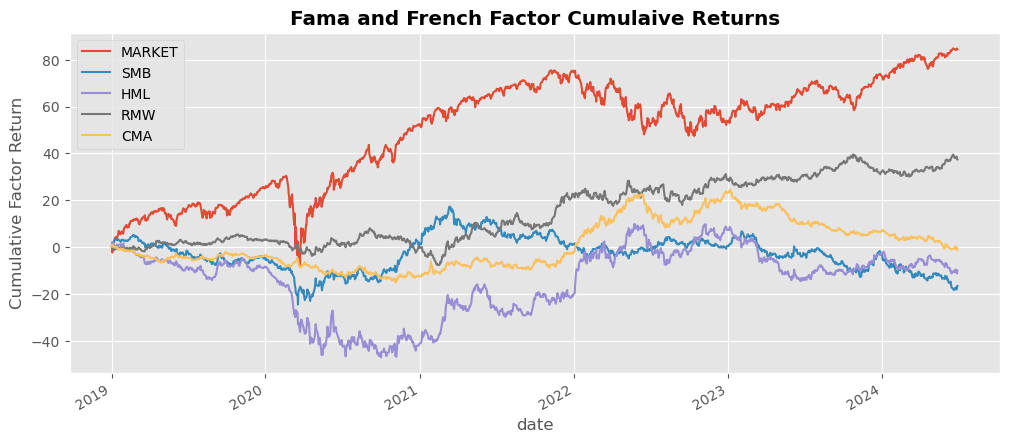

In [5]:
# download the fama-and-french-five-factor data
factor_data = (web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', 
                              start=2019)[0].rename(columns={'Mkt-RF': 'MARKET'}))
factor_data.index.names = ['date']
risk_factor_names = factor_data.columns[:-1].tolist()
# print(factor_data.head())
# print('\n')
# print(factor_data.tail())


plt.rcParams['figure.figsize'] = (12, 5)
factor_data[risk_factor_names].cumsum().plot()
plt.ylabel('Cumulative Factor Return')
plt.title('Fama and French Factor Cumulaive Returns', fontweight='bold')
plt.legend()
plt.show()

### Undiversified Portfolio

[*********************100%%**********************]  8 of 8 completed


Estimated Portfolio  Risk in Percentage:  30.4%


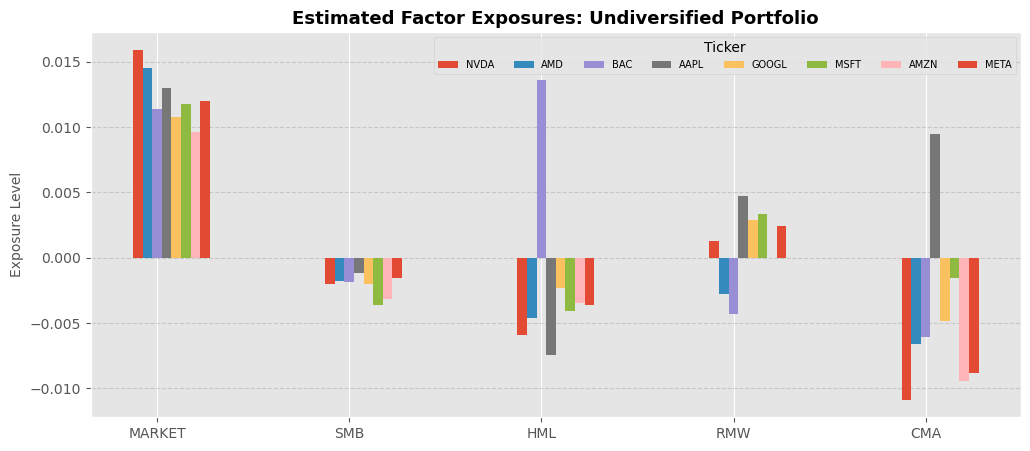

In [26]:
undiversified_ticker_list = ['NVDA', 'AMD','BAC',  'AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', ] 

historical_data = yf.download(tickers=undiversified_ticker_list, start='2019-08-08', end='2024-08-09')
close_prices = historical_data['Adj Close']
daily_ret = close_prices.pct_change().dropna()
# print(daily_ret.head())
daily_ret.index.name = 'date'
daily_ret.columns.name = ''

undiversified_portfolio = portfolio_risk_and_beta_estimates(undiversified_ticker_list, daily_ret, factor_data, risk_factor_names)

undiversified_risk_p = undiversified_portfolio.estimate_portfolio_risk(252)

undiversified_portfolio.plot_estimated_risk_exposures(title='Estimated Factor Exposures: Undiversified Portfolio')

### Diversified Portfolio

[*********************100%%**********************]  12 of 12 completed



Estimated Portfolio  Risk in Percentage:  21.6%


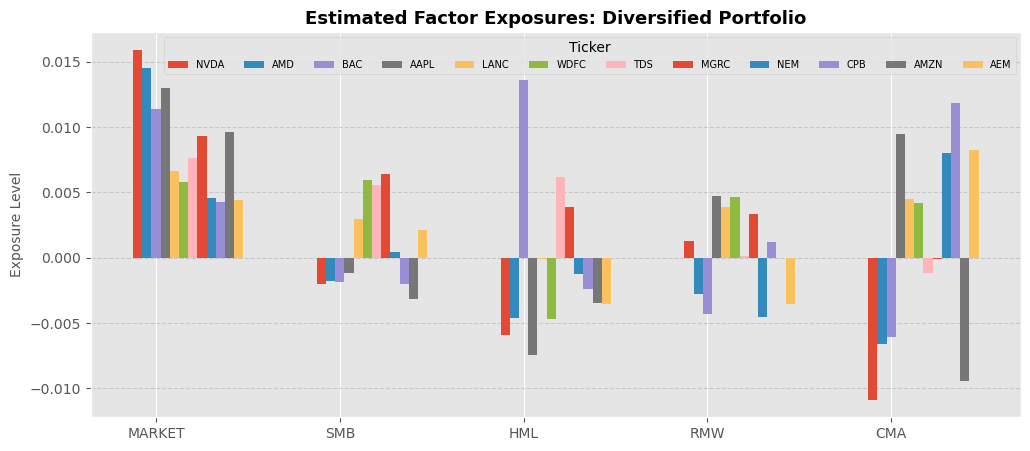

In [25]:
diversified_ticker_list = ['NVDA', 'AMD', 'BAC', 'AAPL', 'LANC', 'WDFC','TDS',  'MGRC', 'NEM', 'CPB', 'AMZN', 'AEM'] # GOLD
historical_data = yf.download(tickers=diversified_ticker_list, start='2019-08-08', end='2024-08-09')
diversified_close_prices = historical_data['Adj Close']
diversified_daily_ret = diversified_close_prices.pct_change().dropna()
# print(daily_ret.head())
diversified_daily_ret.index.name = 'date'
diversified_daily_ret.columns.name = ''

diversified_portfolio = portfolio_risk_and_beta_estimates(diversified_ticker_list, diversified_daily_ret, factor_data, risk_factor_names)

diversified_risk_p = diversified_portfolio.estimate_portfolio_risk(252)

diversified_portfolio.plot_estimated_risk_exposures(title='Estimated Factor Exposures: Diversified Portfolio')


### Diversification result

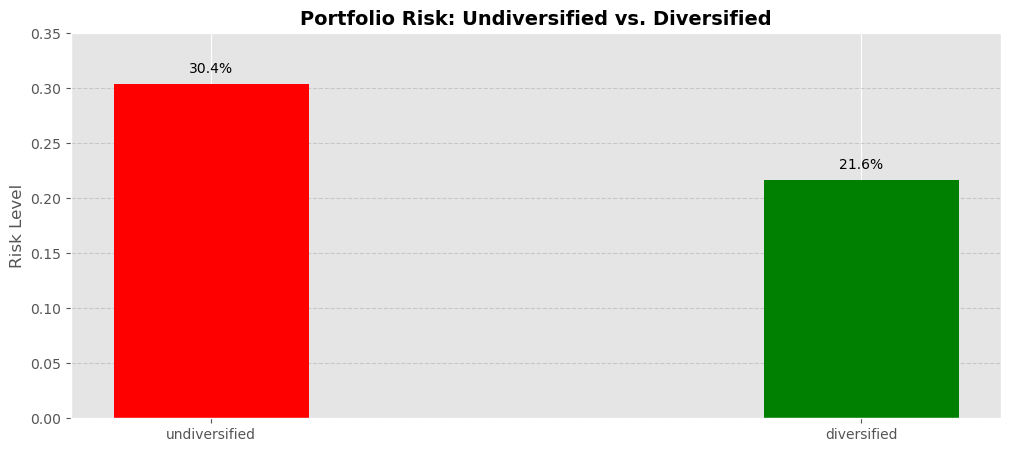

In [9]:
result = pd.DataFrame({'undiversified':[undiversified_risk_p], 'diversified':[diversified_risk_p]}, index=['portfolio_risk'])


fig, ax = plt.subplots()

ax.bar('undiversified', result['undiversified'], color='red', width=0.3)
ax.bar('diversified', result['diversified'], color='green', width=0.3)

ax.text(0, result['undiversified'] + 0.01, '30.4%', ha='center')
ax.text(1, result['diversified'] + 0.01, '21.6%', ha='center')

plt.ylabel('Risk Level')
plt.title('Portfolio Risk: Undiversified vs. Diversified', fontsize=14, fontweight='bold')

plt.ylim(0, 0.35)

plt.grid(axis='y', color='gray', linestyle='--', alpha=.3)

plt.xticks(rotation=0)
plt.show()
